# Intro
This notebook accompanies the kick-off of a small series of posts on predictive maintenance on NASA's turbofan engine degradation dataset (CMAPSS). You can find the accompanying blog posts [here](https://towardsdatascience.com/predictive-maintenance-of-turbofan-engines-ec54a083127?source=friends_link&sk=e97778a1d99d9923f1683365c21a1efb)  

Note: There are 4 datasets available of increasing complexity:  
Data Set FD001 is the first in the series and the least complex.  
Train trjectories: 100  
Test trajectories: 100  
Conditions: ONE (Sea Level)  
Fault Modes: ONE (HPC Degradation)  

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import matplotlib.pyplot as plt 
import seaborn as sns
import matplotlib.ticker as tick
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RandomizedSearchCV

import xgboost

Let's dig in by loading the data and starting our Exploratory Data Analysis (EDA) by inspecting the first few rows, to get a feeling for what the data looks like

In [2]:
# define filepath to read data
dir_path = './Challenge_Data/'

# define column names for easy indexing
index_names = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i) for i in range(1,22)] 
col_names = index_names + setting_names + sensor_names

# read data
train = pd.read_csv((dir_path+'train.txt'), sep='\s+', header=None, names=col_names)
test = pd.read_csv((dir_path+'test.txt'), sep='\s+', header=None, names=col_names)

train.head()

unit_nr  time_cycles  setting_1  setting_2  setting_3     s_1     s_2  \
0        1            1    10.0047     0.2501       20.0  489.05  604.13   
1        1            2     0.0015     0.0003      100.0  518.67  642.13   
2        1            3    34.9986     0.8401       60.0  449.44  555.42   
3        1            4    20.0031     0.7005        0.0  491.19  607.03   
4        1            5    42.0041     0.8405       40.0  445.00  549.52   

       s_3      s_4    s_5  ...    s_12     s_13     s_14    s_15  s_16  s_17  \
0  1499.45  1309.95  10.52  ...  372.15  2388.13  8120.83  8.6216  0.03   368   
1  1584.55  1403.96  14.62  ...  521.81  2388.15  8132.87  8.3907  0.03   391   
2  1368.17  1122.49   5.48  ...  183.26  2387.95  8063.84  9.3557  0.02   334   
3  1488.44  1249.18   9.35  ...  314.84  2388.07  8052.30  9.2231  0.02   364   
4  1354.48  1124.32   3.91  ...  130.44  2387.89  8083.67  9.2986  0.02   330   

   s_18   s_19   s_20     s_21  
0  2319  100.0  28.58  17.1735  
1  2388  100.0  38.99  23.3619  
2  2223  100.0  14.83   8.8555  
3  2324  100.0  24.42  14.7832  
4  2212  100.0  10.99   6.4025  

[5 rows x 26 columns]

## Descriptive statistics

In [3]:
# inspect unit_nr
train[index_names].describe()

unit_nr   time_cycles
count  45918.000000  45918.000000
mean     109.396511    110.307396
std       62.866193     68.420545
min        1.000000      1.000000
25%       54.000000     53.000000
50%      110.000000    106.000000
75%      164.000000    160.000000
max      218.000000    357.000000

In [4]:
# inspect time cycles
train[index_names].groupby('unit_nr').max().describe()

time_cycles
count   218.000000
mean    210.633028
std      43.595578
min     128.000000
25%     177.000000
50%     209.500000
75%     236.000000
max     357.000000

In [5]:
# inspect settings
train[setting_names].describe()

setting_1     setting_2     setting_3
count  45918.000000  45918.000000  45918.000000
mean      24.008881      0.571251     49.172438
std       14.793676      0.310935     32.503659
min        0.000000      0.000000      0.000000
25%       10.004500      0.250600     20.000000
50%       25.001500      0.700000     40.000000
75%       41.998100      0.840000     80.000000
max       42.008000      0.842000    100.000000

In [6]:
# inspect sensor values
train[sensor_names].describe().transpose()

count         mean         std        min          25%        50%  \
s_1   45918.0   472.861677   26.460179   445.0000   445.000000   462.5400   
s_2   45918.0   579.596770   37.391068   535.6500   549.580000   555.9850   
s_3   45918.0  1419.947816  106.286960  1245.4300  1352.910000  1369.1400   
s_4   45918.0  1205.669194  119.550936  1029.4900  1124.010000  1138.8700   
s_5   45918.0     8.029878    3.627125     3.9100     3.910000     7.0500   
s_6   45918.0    11.596773    5.451857     5.7100     5.720000     9.0300   
s_7   45918.0   282.469820  146.539301   136.7500   139.662500   194.6300   
s_8   45918.0  2228.406355  145.582047  1914.8500  2211.850000  2223.0500   
s_9   45918.0  8523.545525  336.780672  7988.7400  8320.740000  8359.4350   
s_10  45918.0     1.094971    0.127832     0.9300     1.020000     1.0200   
s_11  45918.0    42.991879    3.243475    36.2100    41.930000    42.3900   
s_12  45918.0   265.943344  138.163656   129.2400   131.360000   183.1700   
s_13  45918.0  2334.185381  128.426495  2027.7200  2387.880000  2388.0700   
s_14  45918.0  8065.548831   84.964099  7851.5900  8061.230000  8081.4750   
s_15  45918.0     9.332433    0.751834     8.3253     8.676925     9.3145   
s_16  45918.0     0.023354    0.004722     0.0200     0.020000     0.0200   
s_17  45918.0   348.293915   27.837602   303.0000   331.000000   335.0000   
s_18  45918.0  2228.342654  145.693883  1915.0000  2212.000000  2223.0000   
s_19  45918.0    97.741699    5.378969    84.9300   100.000000   100.0000   
s_20  45918.0    20.776822    9.903697    10.2300    10.840000    14.8700   
s_21  45918.0    12.466282    5.941954     6.1266     6.504600     8.9252   

            75%        max  
s_1    491.1900   518.6700  
s_2    607.3700   644.4300  
s_3   1499.6975  1614.6600  
s_4   1307.4375  1442.3600  
s_5     10.5200    14.6200  
s_6     15.4900    21.6100  
s_7    394.1000   555.7200  
s_8   2323.9600  2388.3600  
s_9   8777.1700  9216.8300  
s_10     1.2600     1.3000  
s_11    45.3800    48.3900  
s_12   371.2500   523.4600  
s_13  2388.1600  2390.7400  
s_14  8126.3800  8274.8800  
s_15     9.3900    11.0826  
s_16     0.0300     0.0300  
s_17   369.0000   398.0000  
s_18  2324.0000  2388.0000  
s_19   100.0000   100.0000  
s_20    28.4700    39.3300  
s_21    17.0842    23.5905

In [7]:
# before we start plotting the data, let's compute RUL

In [8]:
train[train['unit_nr'] == 1]

unit_nr  time_cycles  setting_1  setting_2  setting_3     s_1     s_2  \
0          1            1    10.0047     0.2501       20.0  489.05  604.13   
1          1            2     0.0015     0.0003      100.0  518.67  642.13   
2          1            3    34.9986     0.8401       60.0  449.44  555.42   
3          1            4    20.0031     0.7005        0.0  491.19  607.03   
4          1            5    42.0041     0.8405       40.0  445.00  549.52   
..       ...          ...        ...        ...        ...     ...     ...   
218        1          219    35.0073     0.8400       60.0  449.44  556.39   
219        1          220    35.0027     0.8400       60.0  449.44  556.65   
220        1          221     0.0008     0.0000      100.0  518.67  643.88   
221        1          222    20.0003     0.7001        0.0  491.19  608.00   
222        1          223    34.9992     0.8400       60.0  449.44  556.60   

         s_3      s_4    s_5  ...    s_12     s_13     s_14    s_15  s_16  \
0    1499.45  1309.95  10.52  ...  372.15  2388.13  8120.83  8.6216  0.03   
1    1584.55  1403.96  14.62  ...  521.81  2388.15  8132.87  8.3907  0.03   
2    1368.17  1122.49   5.48  ...  183.26  2387.95  8063.84  9.3557  0.02   
3    1488.44  1249.18   9.35  ...  314.84  2388.07  8052.30  9.2231  0.02   
4    1354.48  1124.32   3.91  ...  130.44  2387.89  8083.67  9.2986  0.02   
..       ...      ...    ...  ...     ...      ...      ...     ...   ...   
218  1381.50  1149.74   5.48  ...  182.52  2388.11  8068.10  9.4265  0.02   
219  1375.43  1149.45   5.48  ...  182.73  2388.15  8068.06  9.4148  0.02   
220  1593.26  1425.82  14.62  ...  520.04  2388.28  8139.03  8.5363  0.03   
221  1494.99  1270.18   9.35  ...  313.64  2388.37  8065.53  9.2846  0.03   
222  1385.96  1150.47   5.48  ...  182.61  2388.18  8070.86  9.4489  0.02   

     s_17  s_18   s_19   s_20     s_21  
0     368  2319  100.0  28.58  17.1735  
1     391  2388  100.0  38.99  23.3619  
2     334  2223  100.0  14.83   8.8555  
3     364  2324  100.0  24.42  14.7832  
4     330  2212  100.0  10.99   6.4025  
..    ...   ...    ...    ...      ...  
218   337  2223  100.0  14.82   8.7966  
219   338  2223  100.0  14.75   8.8290  
220   394  2388  100.0  38.67  23.0218  
221   369  2324  100.0  24.28  14.5645  
222   337  2223  100.0  14.70   8.6695  

[223 rows x 26 columns]

In [9]:
def add_remaining_useful_life(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unit_nr")
    max_cycle = grouped_by_unit["time_cycles"].max()
    
    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_nr', right_index=True)
    
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["time_cycles"]
    result_frame["RUL"] = remaining_useful_life
    
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame

train = add_remaining_useful_life(train)
train[index_names+['RUL']].head()

unit_nr  time_cycles  RUL
0        1            1  222
1        1            2  221
2        1            3  220
3        1            4  219
4        1            5  218

## Plotting

#### Colors

In [10]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_blue = ["#21484A", '#2D696C', '#46A3A9', '#5CD8E0', '#B6F4F8']
colors_red  = ["#461818", '#6F2525', '#A03535', '#E14B4B', '#FF5151']

In [11]:
# code for creating custom cmap
# ref: https://stackoverflow.com/a/50230769/12033506

def NonLinCdict(steps, hexcol_array):
    cdict = {'red': (), 'green': (), 'blue': ()}
    for s, hexcol in zip(steps, hexcol_array):
        rgb =mpl.colors.hex2color(hexcol)
        cdict['red'] = cdict['red'] + ((s, rgb[0], rgb[0]),)
        cdict['green'] = cdict['green'] + ((s, rgb[1], rgb[1]),)
        cdict['blue'] = cdict['blue'] + ((s, rgb[2], rgb[2]),)
    return cdict

th = [0, 0.4, 0.5, 0.8, 1]
cdict = NonLinCdict(th, (colors_blue[:4] + colors_dark[-1:])[::-1])
cm = LinearSegmentedColormap('test', cdict)
cm

In [12]:
def reformat_large_tick_values(tick_val, pos):
    """
    Turns large tick values (in the billions, millions and thousands) such as 4500 into 4.5K and also appropriately turns 4000 into 4K (no zero after the decimal).
    """
    if tick_val >= 1000000000:
        val = round(tick_val/1000000000, 1)
        new_tick_format = '{:}B'.format(val)
    elif tick_val >= 1000000:
        val = round(tick_val/1000000, 1)
        new_tick_format = '{:}M'.format(val)
    elif tick_val >= 1000:
        val = round(tick_val/1000, 1)
        new_tick_format = '{:}K'.format(val)
    elif tick_val < 1000:
        new_tick_format = round(tick_val, 1)
    else:
        new_tick_format = tick_val

    # make new_tick_format into a string value
    new_tick_format = str(new_tick_format)
    
    # code below will keep 4.5M as is but change values such as 4.0M to 4M since that zero after the decimal isn't needed
    index_of_decimal = new_tick_format.find(".")
    
    if index_of_decimal != -1:
        value_after_decimal = new_tick_format[index_of_decimal+1]
        if value_after_decimal == "0":
            # remove the 0 after the decimal point since it's not needed
            new_tick_format = new_tick_format[0:index_of_decimal] + new_tick_format[index_of_decimal+2:]
            
    return new_tick_format

### Missing Values

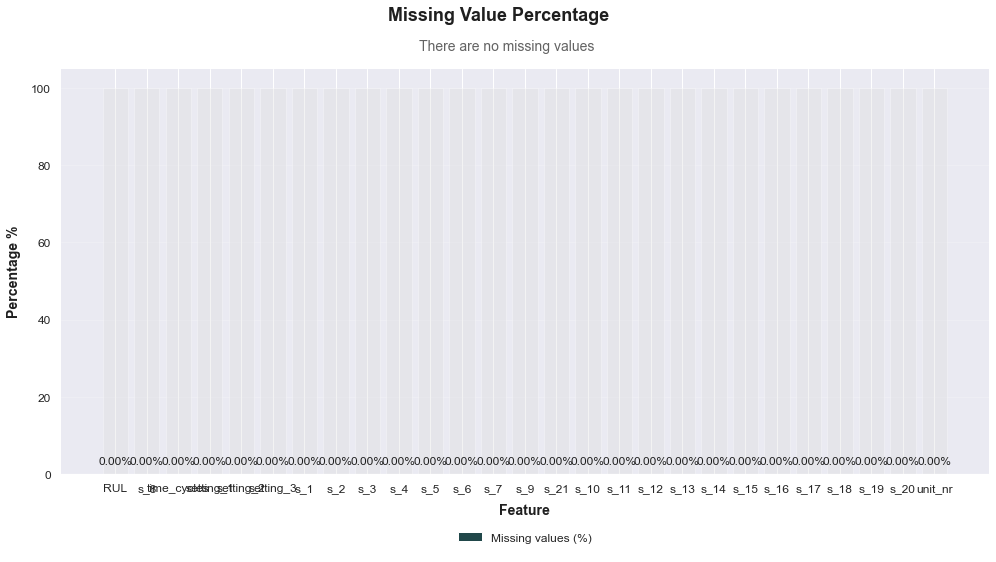

In [13]:
train_null = (train.isnull().sum() / len(train) * 100).sort_values(ascending=False)
train_notnull = (train.notnull().sum() / len(train) * 100).sort_values()

fig, ax = plt.subplots(figsize=(14, 8))

bars1 = ax.bar(x=train_null.index, height=train_null.values, color=colors_blue[0])
bars2 = ax.bar(x=train_notnull.index, height=train_notnull.values, bottom=train_null.values, alpha=0.3, color=colors_dark[-1])

for bar in bars1: 
    height = bar.get_height()
    x = bar.get_x()
    
    ax.text(
        x=x+0.4, y=height + 2.5,
        ha='center',
        s="{:.2f}%".format(height),
        fontsize=12,
        color=colors_dark[0],
    )

ax.legend(["Missing values (%)"], loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=5, borderpad=1, frameon=False, fontsize=12)
ax.grid(axis='y', alpha=0.2)
ax.set_axisbelow(True)
ax.tick_params(labelsize=12)
ax.set_xlabel("Feature", fontsize=14, labelpad=10, fontweight='bold', color=colors_dark[0])
ax.set_ylabel("Percentage %", fontsize=14, labelpad=10, fontweight='bold', color=colors_dark[0])

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.suptitle("Missing Value Percentage", fontsize=18, fontweight='bold', color=colors_dark[0])
plt.title("There are no missing values", loc='center', x=0.48, y=1.03, fontsize=14, color=colors_dark[2])
plt.tight_layout()
plt.show()

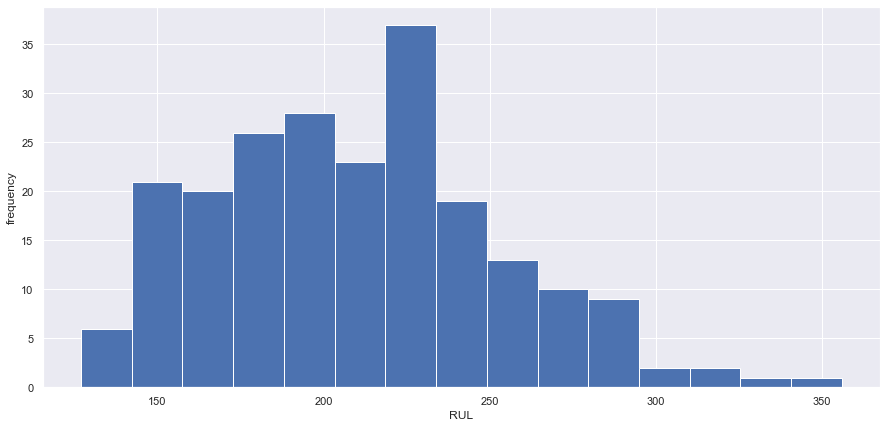

In [14]:
# distribution of RUL, similar to the 'describe function' of time_cycles above, but visual
df_max_rul = train[['unit_nr', 'RUL']].groupby('unit_nr').max().reset_index()
df_max_rul['RUL'].hist(bins=15, figsize=(15,7))
plt.xlabel('RUL')
plt.ylabel('frequency')
plt.show()

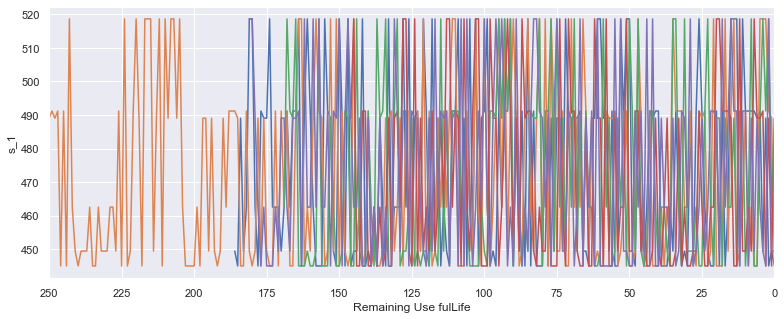

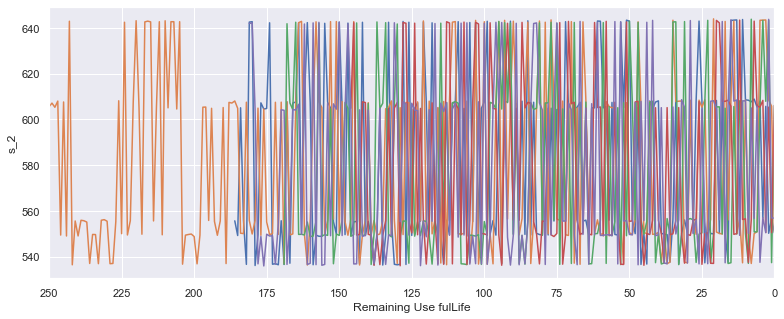

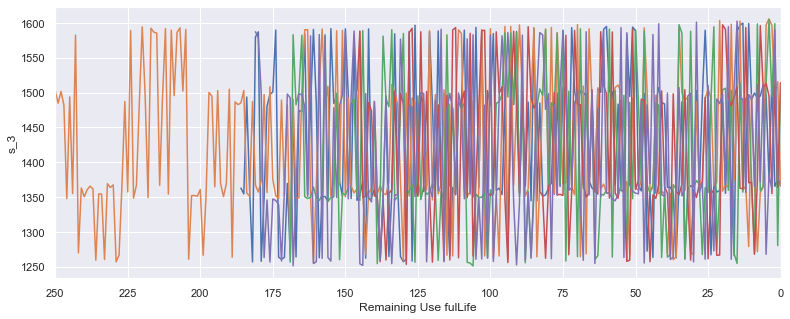

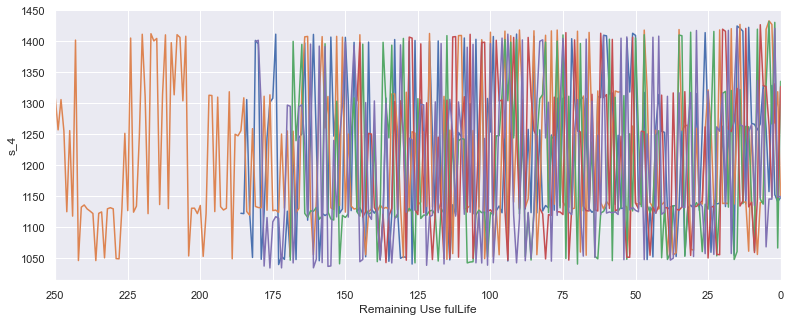

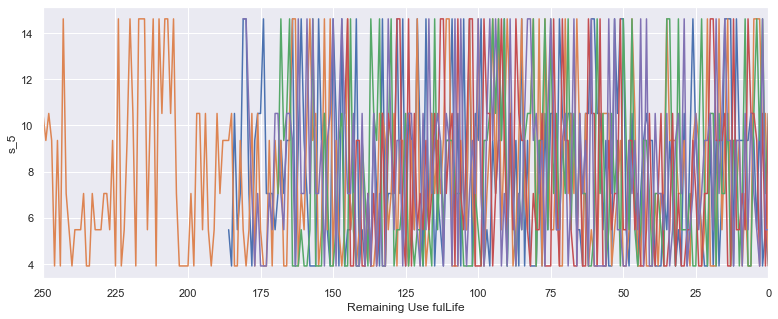

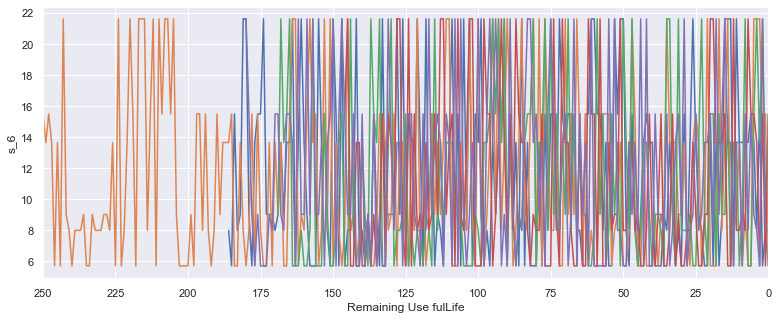

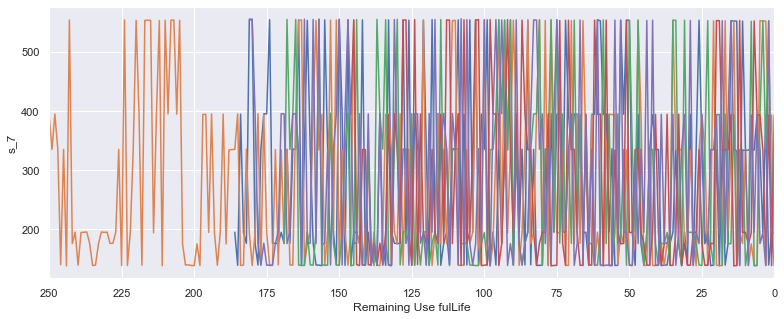

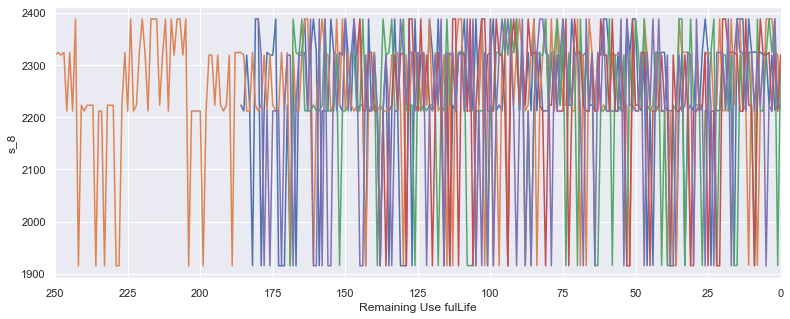

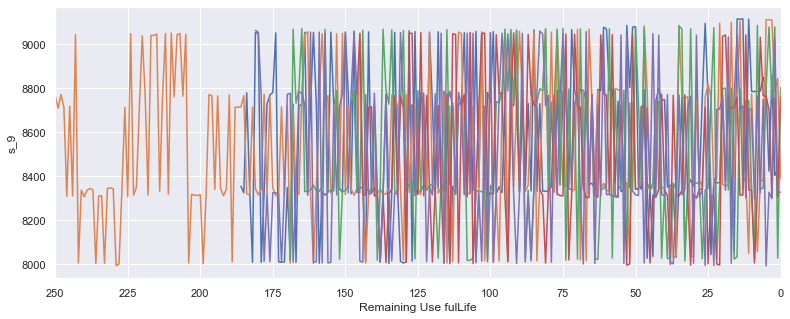

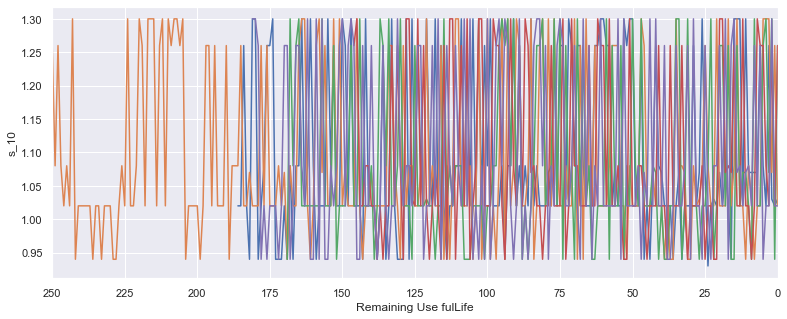

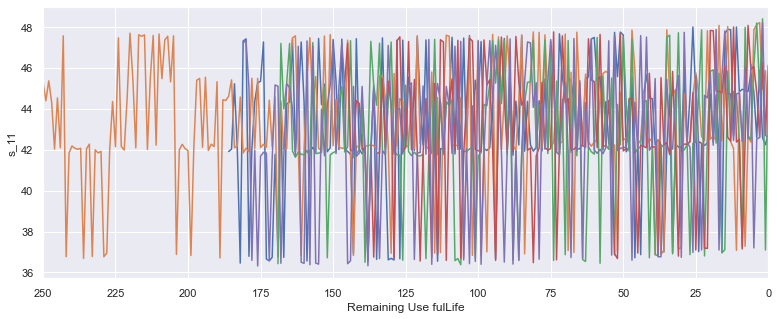

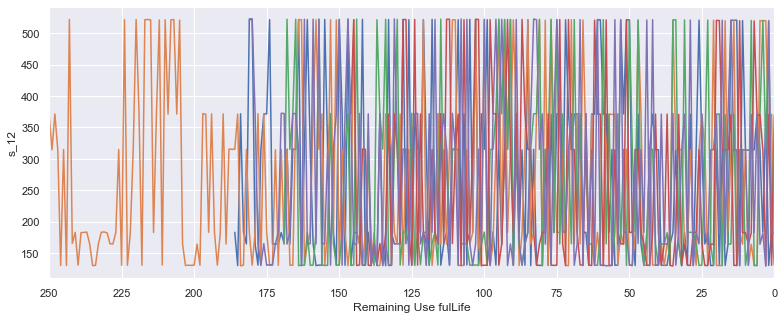

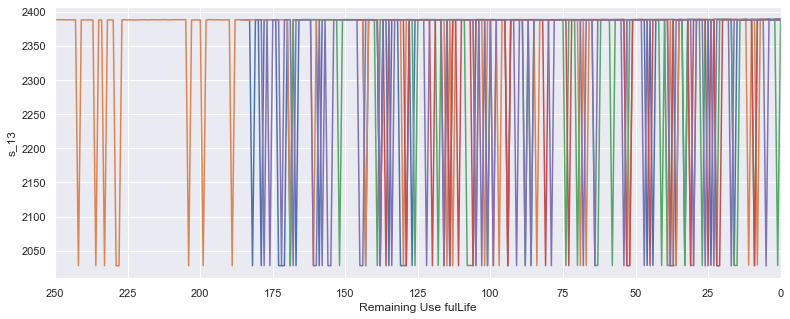

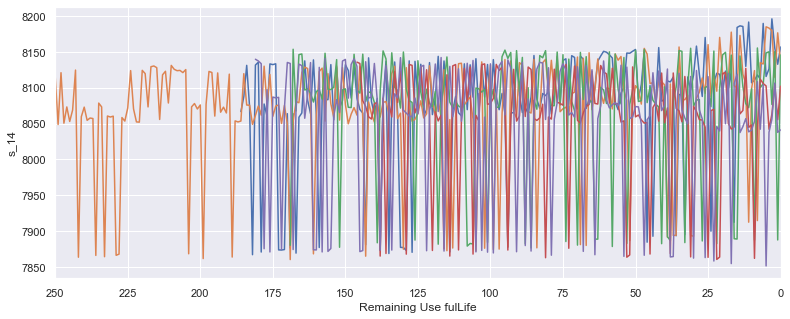

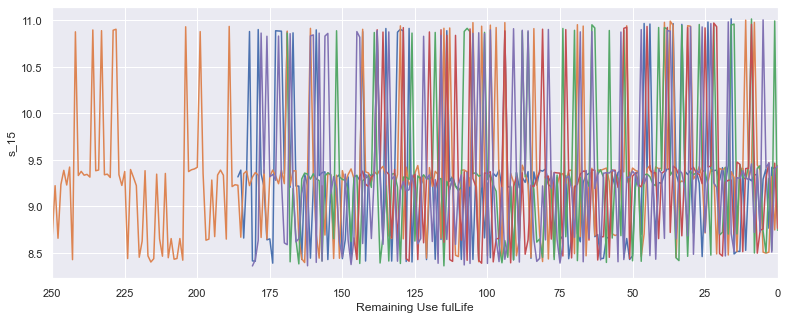

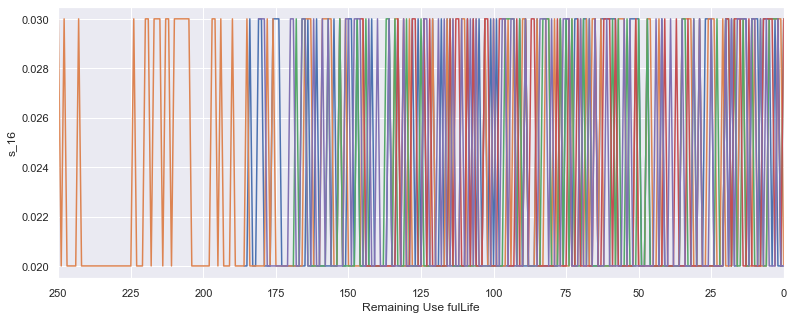

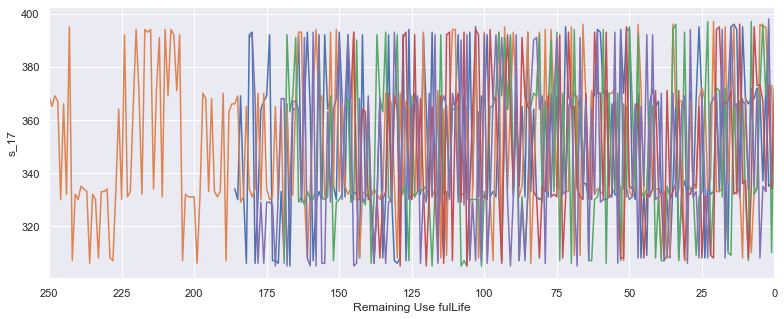

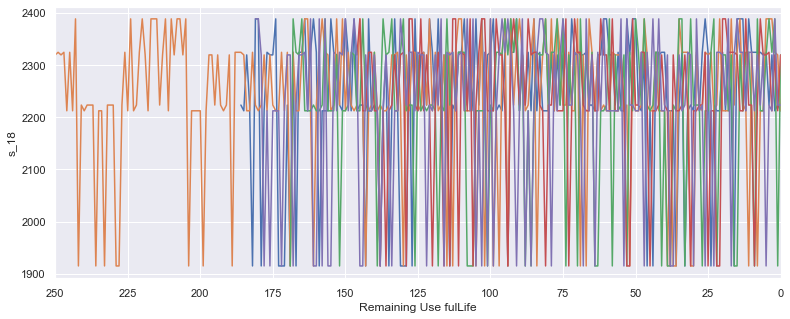

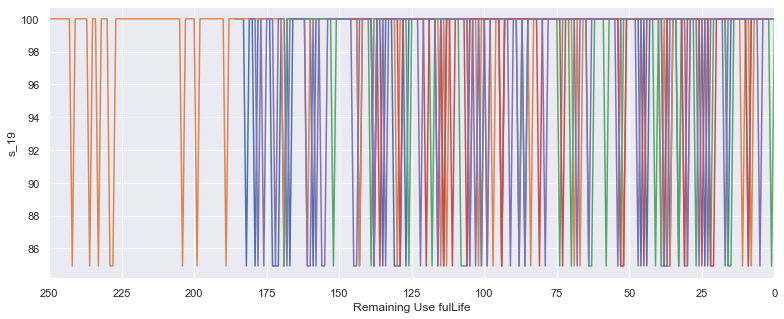

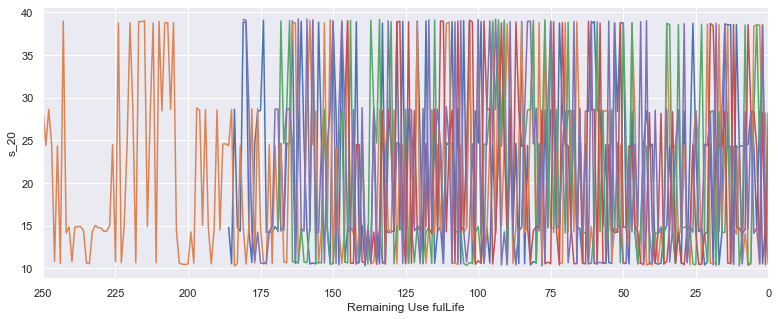

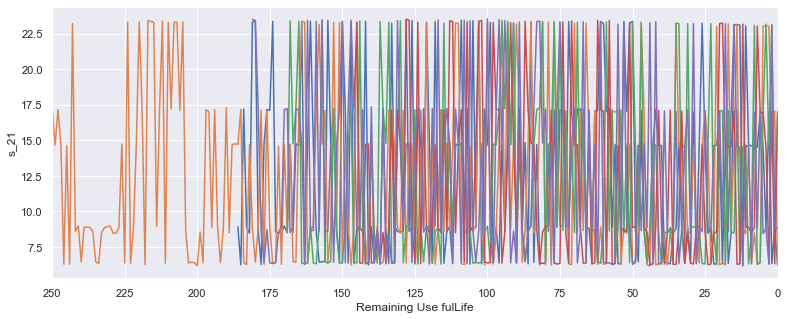

In [16]:
def plot_sensor(sensor_name):
    plt.figure(figsize=(13,5))
    for i in train['unit_nr'].unique():
        if (i % 40 == 0):  # only plot every 10th unit_nr
            plt.plot('RUL', sensor_name, 
                     data=train[train['unit_nr']==i])
    plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero
    plt.xticks(np.arange(0, 275, 25))
    plt.ylabel(sensor_name)
    plt.xlabel('Remaining Use fulLife')
    plt.show()

for sensor_name in sensor_names:
    plot_sensor(sensor_name)

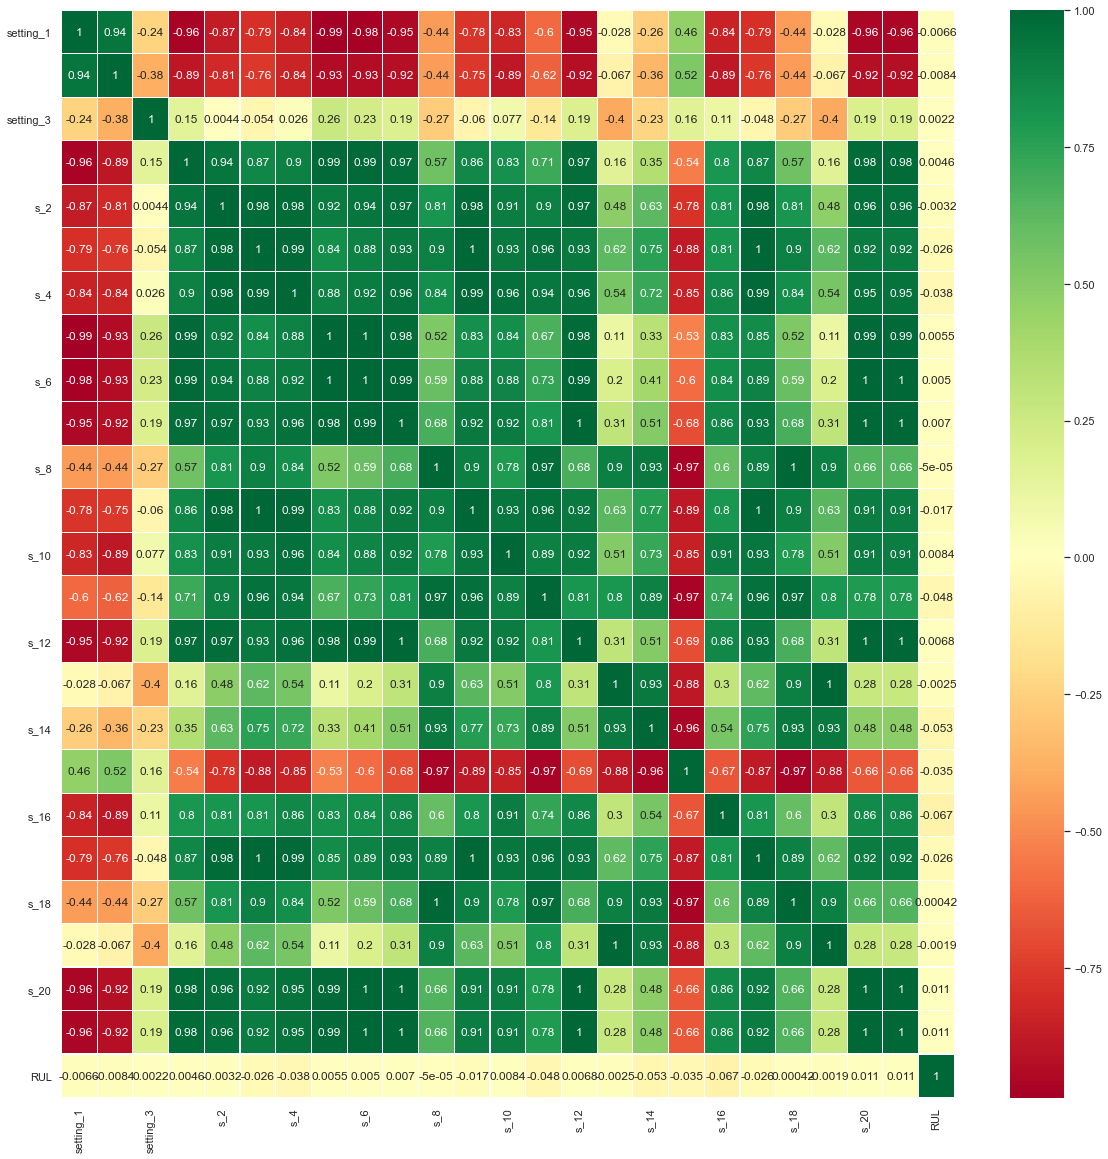

In [18]:
# drop_sensors = ['s_1','s_5','s_6','s_10','s_16','s_18','s_19']
drop_labels = index_names
corr_df = train.drop(drop_labels, axis =1)
sns.heatmap(corr_df.corr(),annot=True,cmap='RdYlGn',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(20,20)
plt.show()

## XGBoost Regression

In [10]:
# first create an evaluate function
def evaluate(y_true, y_hat, label='Test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))

In [11]:
def split_engines(data, split_size = 0.8):
    return data[data.unit_nr < int(data.unit_nr.max() * split_size)], data[data.unit_nr >= int(data.unit_nr.max() * split_size)]

In [12]:
# drop unwanted columns and split target variable from training set
# drop_sensors = ['s_1','s_5','s_6','s_10','s_16','s_18','s_19']
drop_labels = index_names

train_s, val_s = split_engines(train)
X_train = train_s.drop(drop_labels, axis=1)
y_train = X_train.pop('RUL')

X_val = val_s.drop(drop_labels, axis=1)
y_val = X_val.pop('RUL')

# Since the true RUL values for the test set are only provided for the last time cycle of each enginge, 
# the test set is subsetted to represent the same
X_test = test.groupby('unit_nr').last().reset_index().drop(drop_labels, axis=1)


print(X_train.columns)  # check remaining columns

Index(['setting_1', 'setting_2', 'setting_3', 's_1', 's_2', 's_3', 's_4',
       's_5', 's_6', 's_7', 's_8', 's_9', 's_10', 's_11', 's_12', 's_13',
       's_14', 's_15', 's_16', 's_17', 's_18', 's_19', 's_20', 's_21'],
      dtype='object')


In [33]:
# create an xgboost regression model
xgb_reg = xgboost.XGBRegressor(tree_method = "gpu_hist", predictor = "gpu_predictor", n_jobs = 4, verbosity = 1, n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
# evaluate model
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.1, gamma=0,
             gpu_id=0, importance_type='gain', interaction_constraints='',
             learning_rate=0.100000001, max_delta_step=0, max_depth=7,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=4, num_parallel_tree=1,
             predictor='gpu_predictor', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.7,
             tree_method='gpu_hist', validate_parameters=1, verbosity=1)

In [34]:
y_hat = xgb_reg.predict(X_val)
y_train_pred = xgb_reg.predict(X_train)
evaluate(y_train, y_train_pred, label = "Train")
evaluate(y_val, y_hat)

Train set RMSE:13.833670292098354, R2:0.9593856087584057
Test set RMSE:43.76096242409655, R2:0.5802283724237074


# Fine tuning

In [13]:
xgb_clf = xgboost.XGBRegressor(tree_method = "gpu_hist", predictor = "gpu_predictor", verbosity = 1,
                           objective = "reg:squarederror")
# Create parameter grid
parameters = {"learning_rate": [0.1, 0.01, 0.001],
               "gamma" : [0.01, 0.1, 0.3, 0.5, 1, 1.5, 2],
               "max_depth": [2, 4, 7, 10],
               "colsample_bytree": [0.3, 0.6, 0.8, 1.0],
               "subsample": [0.2, 0.4, 0.5, 0.6, 0.7],
               "reg_alpha": [0, 0.5, 1],
               "reg_lambda": [1, 1.5, 2, 3, 4.5],
               "min_child_weight": [1, 3, 5, 7],
               "n_estimators": [100, 250, 500, 1000]}

# Create RandomizedSearchCV Object
xgb_rscv = RandomizedSearchCV(xgb_clf, param_distributions = parameters, scoring = "neg_mean_squared_error",
                             cv = 5, verbose = 3, random_state = 42, n_jobs = 6, n_iter=200)

# Fit the model
model_xgboost = xgb_rscv.fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:  1.2min
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed: 22.8min
[Parallel(n_jobs=6)]: Done 276 tasks      | elapsed: 44.3min
[Parallel(n_jobs=6)]: Done 500 tasks      | elapsed: 75.4min
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed: 111.9min
[Parallel(n_jobs=6)]: Done 1000 out of 1000 | elapsed: 133.9min finished


In [14]:
xgb_rscv.best_score_

-1650.5777052147805

In [15]:
# Model best estimators
lr = model_xgboost.best_estimator_.get_params()["learning_rate"]
gam = model_xgboost.best_estimator_.get_params()["gamma"]
m_dep = model_xgboost.best_estimator_.get_params()["max_depth"]
sub_smp = model_xgboost.best_estimator_.get_params()["subsample"]
col_smp = model_xgboost.best_estimator_.get_params()["colsample_bytree"]
alp = model_xgboost.best_estimator_.get_params()["reg_alpha"]
lamb = model_xgboost.best_estimator_.get_params()["reg_lambda"]
m_chld_w = model_xgboost.best_estimator_.get_params()["min_child_weight"]
n_est = model_xgboost.best_estimator_.get_params()["n_estimators"]
print("Learning Rate: ", lr)
print("Gamma: ", gam)
print("Max Depth: ", m_dep)
print("Subsample: ", sub_smp)
print("Max Features at Split: ", col_smp)
print("Alpha: ", alp)
print("Lamda: ", lamb)
print("Minimum Sum of the Instance Weight Hessian to Make a Child: ", m_chld_w)
print("Number of Trees: ", n_est)

Learning Rate:  0.01
Gamma:  0.1
Max Depth:  10
Subsample:  0.2
Max Features at Split:  0.6
Alpha:  0.5
Lamda:  1
Minimum Sum of the Instance Weight Hessian to Make a Child:  5
Number of Trees:  500


## Now we train with new params

In [16]:
# create an xgboost regression model
xgb_reg = xgboost.XGBRegressor(tree_method = "gpu_hist", predictor = "gpu_predictor", verbosity = 2, 
                               n_estimators=n_est, max_depth=m_dep, subsample=sub_smp, colsample_bytree=col_smp,
                               learning_rate = lr, reg_alpha = alp, reg_lambda = lamb, min_child_weight = m_chld_w)
# evaluate model
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0, gpu_id=0,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=10,
             min_child_weight=5, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=12, num_parallel_tree=1,
             predictor='gpu_predictor', random_state=0, reg_alpha=0.5,
             reg_lambda=1, scale_pos_weight=1, subsample=0.2,
             tree_method='gpu_hist', validate_parameters=1, verbosity=2)

In [17]:
y_hat = xgb_reg.predict(X_val)
y_train_pred = xgb_reg.predict(X_train)
evaluate(y_train, y_train_pred, label = "Train")
evaluate(y_val, y_hat)

Train set RMSE:35.34012027688017, R2:0.7349418555287694
Test set RMSE:42.02021118882788, R2:0.6129600336413965


Got better poj

# Make submission

In [19]:
pred = xgb_reg.predict(X_test)

In [21]:
with open("sub.txt", 'w') as output:
    for row in pred:
        output.write(str(row) + '\n')